In [1]:
import sys, os, time, gc, click, logging, pprint
from os.path import expanduser
from collections import defaultdict
import numpy as np
from mpi4py import MPI
import neuroh5
from neuroh5.io import append_cell_attributes, read_population_ranges, bcast_cell_attributes, \
    scatter_read_cell_attributes, read_cell_attribute_selection, NeuroH5ProjectionGen
import h5py


In [2]:
user_home = expanduser("~")
neuron_home = '%s/bin/nrnpython/lib/python' % user_home
model_home = '%s/src/model' % user_home
dentate_home = '%s/dentate' % model_home
sys.path.append(neuron_home) 
sys.path.append(model_home) 

import dentate
from dentate.env import Env
from dentate import utils, stimulus, synapses
from dentate.utils import *

In [3]:
template_paths='%s/templates' % dentate_home
dataset_prefix='%s/datasets' % dentate_home
config_prefix='%s/config' % dentate_home


In [4]:
destination = 'GC'
sources = ['MPP', 'LPP']
const_sources = ['MC']
config_file='Network_Clamp_GC_Exc_Sat_S_extent.yaml'
output_weights_namespace='Structured Weights'
h5types_path='%s/dentate_h5types.h5' % dataset_prefix
connections_path='%s/Slice/dentatenet_Full_Scale_GC_Exc_Sat_DD_S_extent_20200430A.h5' % dataset_prefix
input_features_path="%s/DG_input_features_20200321_compressed.h5" % dataset_prefix
arena_id='A' 
use_arena_margin=True
coordinates=(0.0, 0.0) 
optimize_tol=1e-4
optimize_grad=True
max_delta_weight=5
gid=47123
initial_weights_path = None
field_width_scale = 1.25
target_amplitude=3.0

In [5]:


np.seterr(all='raise')
os.chdir(dentate_home)
env = Env(config_prefix=config_prefix,config_file=config_file,template_paths=template_paths,dataset_prefix=dataset_prefix)


In [6]:
input_features_namespaces = ['Place Selectivity', 'Grid Selectivity']
this_input_features_namespaces = ['%s %s' % (input_features_namespace, arena_id) 
                                  for input_features_namespace in input_features_namespaces]

selectivity_type_index = { i: n for n, i in viewitems(env.selectivity_types) }
target_selectivity_type_name = 'place'
target_selectivity_type = env.selectivity_types[target_selectivity_type_name]
features_attrs = defaultdict(dict)
source_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate',
                                  'Module ID', 'Grid Spacing', 'Grid Orientation', 'Field Width Concentration Factor', 
                                  'X Offset', 'Y Offset']
target_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate', 
                                  'X Offset', 'Y Offset']

local_random = np.random.RandomState()

seed_offset = int(env.model_config['Random Seeds']['GC Structured Weights'])
spatial_resolution = env.stimulus_config['Spatial Resolution'] # cm

arena = env.stimulus_config['Arena'][arena_id]
default_run_vel = arena.properties['default run velocity']  # cm/s

gid_count = 0
target_gid_set = set([gid])
all_sources = sources + const_sources
 

In [7]:
def generate_structured_weights(target_map, initial_weight_dict, input_rate_map_dict, syn_count_dict,
                                max_delta_weight=10., max_iter=1000, target_amplitude=3., arena_x=None, arena_y=None,
                                const_input_rate_map_dict=None, 
                                reference_weight_dict=None, reference_weights_are_delta=False,
                                reference_weights_namespace='', optimize_method='L-BFGS-B', optimize_tol=1e-6,
                                optimize_grad=False, verbose=False, plot=False, show_fig=False, save_fig=None,
                                fig_kwargs={}):
   

    input_matrix = np.empty((target_map.size, len(input_rate_map_dict)),
                            dtype=np.float32)
    source_gid_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
    syn_count_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
    initial_weight_array = np.empty(len(input_rate_map_dict), dtype=np.float32)

    for i, source_gid in enumerate(input_rate_map_dict):
        source_gid_array[i] = source_gid
        this_syn_count = syn_count_dict[source_gid]
        this_input = input_rate_map_dict[source_gid].ravel() * this_syn_count
        input_matrix[:, i] = this_input
        syn_count_array[i] = this_syn_count
        initial_weight_array[i] = initial_weight_dict[source_gid]

    const_input_matrix = None
    if const_input_rate_map_dict is not None:
        const_input_matrix = np.empty((target_map.size, len(const_input_rate_map_dict)),
                                    dtype=np.float32)
        const_weight_array = np.empty(len(const_input_rate_map_dict), dtype=np.float32)
        for i, source_gid in enumerate(const_input_rate_map_dict):
            this_syn_count = syn_count_dict[source_gid]
            this_input = const_input_rate_map_dict[source_gid].ravel() * this_syn_count
            const_input_matrix[:, i] = this_input
            const_weight_array[i] = 1.
            
    mean_initial_weight = np.mean(initial_weight_array)
    if const_input_matrix is not None:
        initial_background_map = np.dot(input_matrix, initial_weight_array) + np.dot(const_input_matrix, const_weight_array)
    else:
        initial_background_map = np.dot(input_matrix, initial_weight_array)
    background_scaling_factor = np.mean(initial_background_map)
    if background_scaling_factor <= 0.:
        raise RuntimeError('generate_structured_delta_weights: initial weights must produce positive activation')
    initial_background_map /= background_scaling_factor
    initial_background_map -= 1.

    initial_input_map = np.dot(input_matrix, initial_weight_array)
    input_scaling_factor = np.mean(initial_input_map)
    scaled_input_matrix = np.array(np.divide(input_matrix, input_scaling_factor), dtype=np.float32)

    scaled_const_input_map = None
    scaled_const_input_matrix = None
    if const_input_matrix is not None:
        const_input_map = np.dot(const_input_matrix, const_weight_array)
        const_scaling_factor = np.mean(const_input_map)
        scaled_const_input_matrix = np.array(np.divide(const_input_matrix, const_scaling_factor), dtype=np.float32)
        scaled_const_input_map = (const_input_map / const_scaling_factor) - 1.
    
    scaled_target_map = target_map.flat - np.min(target_map)
    if np.max(scaled_target_map) > 0.:
        scaled_target_map /= np.max(scaled_target_map)
    scaled_target_map *= target_amplitude

    flat_scaled_target_map = scaled_target_map.ravel()
    
    ## Compute pseudo inverse of scaled_input_matrix
    #[U, s, Vh] = np.linalg.svd(scaled_input_matrix)
    #V = Vh.T
    #D = np.zeros_like(input_matrix)
    #beta = np.mean(s)  # Previously, beta was provided by user, but should depend on scale if data is not normalized
    #D[np.where(np.eye(*D.shape))] = s / (s ** 2. + beta ** 2.)
    #input_matrix_pinv = V.dot(D.conj().T).dot(U.conj().T)
    #SVD_delta_weights = np.dot(input_matrix_pinv, flat_scaled_target_map)
    lsqr_target_map = np.copy(target_map.flat - np.min(target_map))
    lsqr_target_map /= np.max(lsqr_target_map)
    if scaled_const_input_map is not None:
        lsqr_target_map -= scaled_const_input_map
        lsqr_target_map = np.clip(lsqr_target_map, 0., None)
    lsqr_target_map *= target_amplitude
    res = scipy.sparse.linalg.lsmr(scaled_input_matrix,
                                   lsqr_target_map,
                                   atol=optimize_tol, btol=optimize_tol,
                                   damp=1.0, show=verbose)
    lsqr_delta_weights = np.asarray(res[0], dtype=np.float32)
    flat_lsqr_map = np.dot(scaled_input_matrix, lsqr_delta_weights)
    if scaled_const_input_map is not None:
        flat_lsqr_map += scaled_const_input_map
    
    # bounds = (mean_initial_weight, max_weight)
    bounds = (0., max_delta_weight)
    initial_LS_delta_weights = np.clip(lsqr_delta_weights, bounds[0], bounds[1])


    def activation_map_residual(weights, input_matrix, target_map):
        a = np.dot(np.asarray(input_matrix, dtype=np.float32),
                   np.asarray(weights, dtype=np.float32))
        if scaled_const_input_map is not None:
            a += scaled_const_input_map
        e = np.subtract(target_map, a)
                                           
        res = np.square(e).mean() / 2.
        return np.asarray(res, dtype=np.float64)

    def activation_map_residual_grad(weights, input_matrix, target_map):
        N = weights.shape[0]
        a = np.dot(np.asarray(input_matrix, dtype=np.float32),
                   np.asarray(weights, dtype=np.float32))
        if scaled_const_input_map is not None:
            a += scaled_const_input_map
        e = np.subtract(target_map, a)
        grad = -1./N * np.dot(input_matrix.T, e)
        return np.asarray(grad, dtype=np.float64)

    
    if optimize_method == 'dogbox':
        result = opt.least_squares(activation_map_residual, initial_LS_delta_weights,
                                   jac=activation_map_residual_grad if optimize_grad else None,
                                   args=(scaled_input_matrix, flat_scaled_target_map),
                                   bounds=bounds, method='dogbox', ftol=optimize_tol, loss='soft_l1', 
                                   verbose=2 if verbose else 0, max_nfev=max_iter)
        LS_delta_weights = np.array(result.x)
    elif optimize_method == 'oja':
        from sklearn.decomposition import PCA
        pca = PCA(whiten=True)
        w = pca.fit_transform(initial_LS_delta_weights.reshape((-1, 1)))
        input_matrix = scaled_input_matrix
        tol = optimize_tol
        learning_rate = 1e-4
        it = 0
        while activation_map_residual(w, input_matrix, flat_scaled_target_map) > tol and it < max_iter:
            y = np.dot(input_matrix, w)
            u = np.dot(y, w.T)
            e = input_matrix - u
            dw = learning_rate * np.dot(e.T, y)
            w += dw
            it += 1
            
        LS_delta_weights = np.copy(w)
    else:
        method_options = {'disp': verbose, 'maxiter': max_iter}
        if optimize_method == 'L-BFGS-B':
            method_options['maxfun'] = 1000000
        result = opt.minimize(activation_map_residual,
                              initial_LS_delta_weights, 
                              jac=activation_map_residual_grad if optimize_grad else None,
                              args=(scaled_input_matrix, flat_scaled_target_map),
                              method=optimize_method,
                              bounds=[bounds] * len(initial_LS_delta_weights), tol=optimize_tol,
                              options=method_options)
        LS_delta_weights = np.array(result.x)

    normalized_delta_weights_array = LS_delta_weights / np.max(LS_delta_weights)
    scaled_LS_weights = normalized_delta_weights_array * max_delta_weight + mean_initial_weight
    flat_LS_map = np.dot(np.asarray(scaled_input_matrix, dtype=np.float32),
                         np.asarray(scaled_LS_weights, dtype=np.float32)) - 1.
    if scaled_const_input_map is not None:
        flat_LS_map += scaled_const_input_map
    normalized_delta_weights_dict = dict(zip(source_gid_array, scaled_LS_weights))

    if plot:
        flat_initial_LS_map = np.dot(scaled_input_matrix, initial_LS_delta_weights)
        max_weight = mean_initial_weight + max_delta_weight
        plot_callback_structured_weights(optimize_method = optimize_method,
                                         arena_x = arena_x,
                                         arena_y = arena_y,
                                         bounds = bounds,
                                         max_weight = max_weight,
                                         scaled_const_input_map = scaled_const_input_map,
                                         lsqr_delta_weights = lsqr_delta_weights,
                                         initial_LS_delta_weights = initial_LS_delta_weights,
                                         scaled_LS_weights = scaled_LS_weights,
                                         initial_weight_array = initial_weight_array,
                                         flat_scaled_target_map = flat_scaled_target_map,
                                         flat_lsqr_map = flat_lsqr_map,
                                         flat_initial_LS_map = flat_initial_LS_map,
                                         flat_LS_map = flat_LS_map,
                                         initial_background_map = initial_background_map,
                                         reference_weight_array = reference_weight_array,
                                         reference_weights_are_delta = reference_weights_are_delta,
                                         show_fig=show_fig, save_fig=save_fig,
                                         **fig_kwargs)


    return normalized_delta_weights_dict, flat_LS_map


In [8]:
connection_gen_list = [ NeuroH5ProjectionGen(connections_path, source, destination, namespaces=['Synapses']) 
                        for source in all_sources ]
field_width = None
peak_rate = None
structured_weights_dict = {}

for iter_count, attr_gen_package in enumerate(zip_longest(*connection_gen_list)):
        
        this_gid = attr_gen_package[0][0]
        if not all([attr_gen_items[0] == this_gid for attr_gen_items in attr_gen_package]):
            raise Exception('destination: %s; this_gid not matched across multiple attribute '
                            'generators: %s' % (destination,
                                                [attr_gen_items[0] for attr_gen_items in attr_gen_package]))
        
        if (target_gid_set is not None) and (this_gid not in target_gid_set):
            continue


        if this_gid is None:
            selection = []
            logger.info('received None')
        else:
            selection = [this_gid]
            local_random.seed(int(this_gid + seed_offset))

        has_structured_weights = False

        dst_input_features_attr_dict = {}
        for input_features_namespace in this_input_features_namespaces:
            input_features_iter = read_cell_attribute_selection(input_features_path, destination, 
                                                                namespace=input_features_namespace,
                                                                mask=set(target_features_attr_names), 
                                                                selection=selection)
            count = 0
            for gid, attr_dict in input_features_iter:
                dst_input_features_attr_dict[gid] = attr_dict
                count += 1
            logger.info('Read %s feature data for %i cells in population %s' % (input_features_namespace, count, destination))

        arena_margin = 0.
        target_selectivity_features_dict = {}
        target_selectivity_config_dict = {}
        target_field_width_dict = {}
        for gid in selection:
            target_selectivity_features_dict[gid] = dst_input_features_attr_dict.get(gid, {})
            target_selectivity_features_dict[gid]['Selectivity Type'] = np.asarray([target_selectivity_type], dtype=np.uint8)

            num_fields = target_selectivity_features_dict[gid]['Num Fields'][0]
            
            if coordinates[0] is not None:
                num_fields = 1
                target_selectivity_features_dict[gid]['X Offset'] =  np.asarray([coordinates[0]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Y Offset'] =  np.asarray([coordinates[1]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Num Fields'] = np.asarray([num_fields], dtype=np.uint8)

            if field_width is not None:
                target_selectivity_features_dict[gid]['Field Width'] = np.asarray([field_width]*num_fields, dtype=np.float32)
            else:
                this_field_width = target_selectivity_features_dict[gid]['Field Width']
                target_selectivity_features_dict[gid]['Field Width'] = this_field_width[:num_fields]
                
            if peak_rate is not None:
                target_selectivity_features_dict[gid]['Peak Rate'] = np.asarray([peak_rate]*num_fields, dtype=np.float32)

            input_cell_config = stimulus.get_input_cell_config(target_selectivity_type,
                                                               selectivity_type_index,
                                                               selectivity_attr_dict=target_selectivity_features_dict[gid])
            if input_cell_config.num_fields > 0:
                arena_margin = max(arena_margin, np.max(input_cell_config.field_width) / 2.) if use_arena_margin else 0.
                target_field_width_dict[gid] = input_cell_config.field_width
                target_selectivity_config_dict[gid] = input_cell_config
                has_structured_weights = True

        arena_x, arena_y = stimulus.get_2D_arena_spatial_mesh(arena, spatial_resolution,
                                                              margin=arena_margin)
        for gid, input_cell_config in viewitems(target_selectivity_config_dict):
            target_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y,
                                                                   scale=field_width_scale),
                                    dtype=np.float32)
            target_selectivity_features_dict[gid]['Arena Rate Map'] = target_map

                
        if not has_structured_weights:
            selection = []
                
        initial_weights_by_syn_id_dict = defaultdict(lambda: dict())
        initial_weights_by_source_gid_dict = defaultdict(lambda: dict())

        if initial_weights_path is not None:
            initial_weights_iter = \
              read_cell_attribute_selection(initial_weights_path, destination,
                                            namespace=initial_weights_namespace,
                                            selection=selection)

            initial_weights_gid_count = 0
            for this_gid, syn_weight_attr_dict in initial_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    initial_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                initial_weights_gid_count += 1

            logger.info('destination: %s; read initial synaptic weights for %i gids' %
                        (destination, initial_weights_gid_count))
            
             

        syn_count_by_source_gid_dict = defaultdict(int)
        source_gid_set_dict = defaultdict(set)
        syn_ids_by_source_gid_dict = defaultdict(list)
        structured_syn_id_count = 0

        if has_structured_weights:
            for source, (destination_gid, (source_gid_array, conn_attr_dict)) in zip_longest(all_sources, attr_gen_package):
                syn_ids = conn_attr_dict['Synapses']['syn_id']
                count = 0
                this_initial_weights_by_syn_id_dict = None
                this_initial_weights_by_source_gid_dict = None
                
                if destination_gid is not None:
                    this_initial_weights_by_syn_id_dict = initial_weights_by_syn_id_dict[destination_gid]
                    this_initial_weights_by_source_gid_dict = initial_weights_by_source_gid_dict[destination_gid]
                    

                for i in range(len(source_gid_array)):
                    this_source_gid = source_gid_array[i]
                    this_syn_id = syn_ids[i]
                    this_syn_wgt = this_initial_weights_by_syn_id_dict.get(this_syn_id, 1.0)
                    source_gid_set_dict[source].add(this_source_gid)
                    syn_ids_by_source_gid_dict[this_source_gid].append(this_syn_id)
                    syn_count_by_source_gid_dict[this_source_gid] += 1
                    if this_source_gid not in this_initial_weights_by_source_gid_dict:
                        this_initial_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                    
                    count += 1
                if source not in const_sources:
                    structured_syn_id_count += len(syn_ids)
                logger.info('destination: %s; gid %i; %d edges from source population %s' %
                            (destination, this_gid, count, source))


        input_rate_maps_by_source_gid_dict = {}
        if len(const_sources) > 0:
            const_input_rate_maps_by_source_gid_dict = {}
        else:
            const_input_rate_maps_by_source_gid_dict = None
        for source in all_sources:
            if has_structured_weights:
                source_gids = list(source_gid_set_dict[source])
            else:
                source_gids = []
            logger.info('Reading %s feature data for %i cells in population %s...' % (input_features_namespace, len(source_gids), source))
            for input_features_namespace in this_input_features_namespaces:
                input_features_iter = read_cell_attribute_selection(input_features_path, source, 
                                                                    namespace=input_features_namespace,
                                                                    mask=set(source_features_attr_names), 
                                                                    comm=env.comm, selection=source_gids)
                count = 0
                for gid, attr_dict in input_features_iter:
                    this_selectivity_type = attr_dict['Selectivity Type'][0]
                    this_selectivity_type_name = selectivity_type_index[this_selectivity_type]
                    input_cell_config = stimulus.get_input_cell_config(this_selectivity_type,
                                                                       selectivity_type_index,
                                                                       selectivity_attr_dict=attr_dict)
                    this_arena_rate_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y),
                                                     dtype=np.float32)
                    if source in const_sources:
                        const_input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    else:
                        input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    count += 1
                
                logger.info('Read %s feature data for %i cells in population %s' % (input_features_namespace, count, source))

        if has_structured_weights:

            structured_weights_dict[gid] = \
                {'target_map': target_selectivity_features_dict[this_gid]['Arena Rate Map'],
                 'initial_weight_dict': this_initial_weights_by_source_gid_dict,
                 'input_rate_map_dict': input_rate_maps_by_source_gid_dict,
                 'const_input_rate_map_dict': const_input_rate_maps_by_source_gid_dict,
                 'syn_count_dict': syn_count_by_source_gid_dict,
                 'max_delta_weight': max_delta_weight, 
                 'arena_x': arena_x, 
                 'arena_y': arena_y
                }



In [9]:
target_map = structured_weights_dict[gid]['target_map']
initial_weight_dict = structured_weights_dict[gid]['initial_weight_dict']
input_rate_map_dict = structured_weights_dict[gid]['input_rate_map_dict']
const_input_rate_map_dict = structured_weights_dict[gid]['const_input_rate_map_dict']
syn_count_dict = structured_weights_dict[gid]['syn_count_dict']
arena_x = structured_weights_dict[gid]['arena_x']
arena_y = structured_weights_dict[gid]['arena_y']

input_matrix = np.empty((target_map.size, len(input_rate_map_dict)),
                            dtype=np.float64)
source_gid_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
syn_count_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
initial_weight_array = np.empty(len(input_rate_map_dict), dtype=np.float64)
for i, source_gid in enumerate(input_rate_map_dict):
    source_gid_array[i] = source_gid
    this_syn_count = syn_count_dict[source_gid]
    this_input = input_rate_map_dict[source_gid].ravel() * this_syn_count
    input_matrix[:, i] = this_input
    syn_count_array[i] = this_syn_count
    initial_weight_array[i] = initial_weight_dict[source_gid]

const_input_matrix = None
if const_input_rate_map_dict is not None:
   const_input_matrix = np.empty((target_map.size, len(const_input_rate_map_dict)),
                                 dtype=np.float64)
   const_weight_array = np.empty(len(const_input_rate_map_dict), dtype=np.float64)
   for i, source_gid in enumerate(const_input_rate_map_dict):
        this_syn_count = syn_count_dict[source_gid]
        this_input = const_input_rate_map_dict[source_gid].ravel() * this_syn_count
        const_input_matrix[:, i] = this_input
        const_weight_array[i] = 1.
            


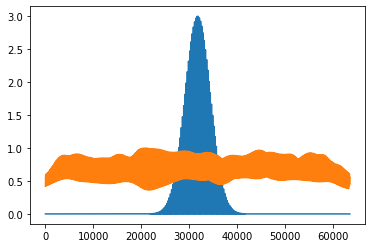

In [10]:
import matplotlib.pyplot as plt

scaled_target_map = np.asarray(target_map.flat - np.min(target_map), dtype=np.float64)
if np.max(scaled_target_map) > 0.:
   target_map_scaling_factor = target_amplitude / np.max(target_map.flat)
   scaled_target_map = scaled_target_map.flat * target_map_scaling_factor


flat_scaled_target_map = scaled_target_map.ravel()
  
mean_initial_weight = np.mean(initial_weight_array)
initial_background_map = np.dot(input_matrix, initial_weight_array)
if np.mean(initial_background_map)<= 0.:
   raise RuntimeError('generate_structured_delta_weights: initial weights must produce positive activation')
scaled_background_map = initial_background_map / np.max(initial_background_map)


plt.figure()
plt.plot(flat_scaled_target_map);
plt.plot(scaled_background_map);



ValueError: operands could not be broadcast together with shapes (63504,2011) (63504,1249) 

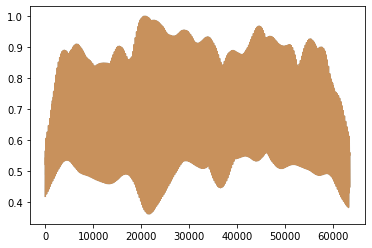

<Figure size 432x288 with 0 Axes>

In [11]:
scaled_input_matrix = input_matrix / np.max(initial_background_map)
plt.figure()
plt.plot(np.dot(scaled_input_matrix, initial_weight_array), alpha=0.6)
plt.plot(scaled_background_map, alpha=0.6);


scaled_const_input_matrix = const_input_matrix / np.max(initial_background_map)
plt.figure()
plt.plot(np.dot(scaled_input_matrix, initial_weight_array)  - 
         np.dot(scaled_const_input_matrix, const_weight_array),
         alpha=0.6);
plt.plot(scaled_background_map, alpha=0.6);


In [ ]:
lsqr_target_map = np.copy(scaled_target_map) - scaled_background_map
res = scipy.sparse.linalg.lsmr(scaled_input_matrix,
                               lsqr_target_map,
                               atol=optimize_tol, btol=optimize_tol,
                               damp=1.0, show=True)
lsqr_delta_weights = np.asarray(res[0], dtype=np.float32)    


In [ ]:
max_weight = 4.0
bounds = (-np.min(initial_weight_array), max_weight - np.max(initial_weight_array))
initial_LS_delta_weights = np.clip(lsqr_delta_weights, bounds[0], bounds[1])

lsqr_input_map = np.dot(scaled_input_matrix, lsqr_delta_weights + initial_weight_array)
LS_input_map = np.dot(scaled_input_matrix, initial_LS_delta_weights + initial_weight_array)
plt.figure()
#plt.plot(lsqr_target_map, alpha=0.6, label='Target');
plt.plot(lsqr_input_map, alpha=0.6, label='LSQR');
plt.plot(LS_input_map, alpha=0.6, label='Truncated LSQR');
plt.legend();

plt.figure();
plt.hist(lsqr_delta_weights, bins=50);


In [ ]:
def activation_map_residual(weights, input_matrix, target_map):
    a = np.dot(input_matrix, weights)
    e = np.subtract(target_map, a)
                                           
    res = np.square(e).mean() / 2.
    return np.asarray(res, dtype=np.float64)

def activation_map_residual_grad(weights, input_matrix, target_map):
    N = weights.shape[0]
    a = np.dot(input_matrix, weights)
    e = np.subtract(target_map, a)
    grad = -1./N * np.dot(input_matrix.T, e)
    return np.asarray(grad, dtype=np.float64)


In [ ]:
import scipy.optimize as opt
optimize_method = 'L-BFGS-B'

method_options = {'disp': True, 'maxiter': 1000}
method_options['maxfun'] = 1000000

result = opt.minimize(activation_map_residual,
                      initial_LS_delta_weights, 
                      jac=activation_map_residual_grad if optimize_grad else None,
                      args=(scaled_input_matrix, lsqr_target_map.flat),
                      method=optimize_method,
                      bounds=[bounds] * len(initial_LS_delta_weights), tol=optimize_tol,
                      options=method_options)
LS_delta_weights = np.array(result.x)


In [ ]:
print(np.min(LS_delta_weights))
print(np.max(LS_delta_weights))
print(np.mean(LS_delta_weights))
print(np.std(LS_delta_weights))

LS_delta_map = np.dot(scaled_input_matrix, LS_delta_weights + initial_weight_array)

plt.plot(lsqr_input_map, alpha=0.6, label="LSQR");
plt.plot(LS_delta_map, alpha=0.6, label="L-BFGS");

plt.legend();

In [ ]:

plt.hist(LS_delta_weights, bins=50, label="LS delta");
#plt.hist(LS_delta_weights + mean_initial_weight, label="LS delta + mean initial");
plt.legend();